# DenseNet (2of2)

DenseNet 121 without 'imagenet' weights

This model freezes all layers, except for the last 8. 

The model uses 40 epochs, and 'rgb' color channel. The DenseNet (and ResNet) only work with RGB

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [2]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size 
batch_size = 40000

# Size of test set (in %)
testsize = 0.3

# Epochs
epoch_t = 40

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

In [3]:
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


**Create new directory for version**

In [4]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/DenseNet"
    for files in os.listdir(dir):
        if "DenseNet" in files: 
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: DenseNet-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v{new_vnum:03}"
    os.makedirs(new_dir)

5 matches(es) found
--------------
New folder name: DenseNet-local-v006
--------------


# Data

In [5]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = "/kaggle/input/checkpoints" 

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = 'C:/Users/Max/Documents/GitHub/dcgan_kaggle_output/dcgan-kaggle-v002/checkpoints'
    

In [6]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

In [7]:
batches = ImageDataGenerator().flow_from_directory(
    directory  = path_root, 
    color_mode = ch, 
    target_size= (ih,iw), 
    interpolation="bicubic",
    class_mode = 'sparse',
    batch_size=batch_size
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [8]:
processed_imgs = tf.keras.applications.resnet.preprocess_input(imgs)
labels = np.array(labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(processed_imgs, labels, test_size=testsize)

In [10]:
trainsize = len(X_train)
testsize = len(X_test)

print(f"Size of training data: {trainsize} | Shape of training data {X_train.shape}")
print(f"Size of training data: {testsize}  | Shape of training data {X_test.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 18583 | Shape of training data (18583, 64, 64, 3)
Size of training data: 7965  | Shape of training data (7965, 64, 64, 3)
Shape of training labels (18583,)
Shape of training labels (7965,)


# ResNet

In [11]:
base_model = tf.keras.applications.DenseNet121(weights = None, include_top = False, input_shape = (64,64,3))

In [12]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(11, activation = 'softmax')(x)

In [13]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [14]:
for layer in head_model.layers[:-8]:
    layer.trainable=False
    
for layer in head_model.layers[-8:]:
    layer.trainable=True

Callbacks

In [15]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)

In [16]:
history = head_model.fit(
    X_train, 
    y_train,
    batch_size=64, 
    epochs=epoch_t, 
    validation_data=(X_test, y_test),
    callbacks = [anne, checkpoint]) # EPOCHS WAS 40

Epoch 1/40
291/291 [==============================] - 51s 128ms/step - loss: 0.4582 - accuracy: 0.8787 - val_loss: 0.4592 - val_accuracy: 0.8677

Epoch 00001: val_loss improved from inf to 0.45915, saving model to /Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v006\model.h5
Epoch 2/40
291/291 [==============================] - 33s 115ms/step - loss: 0.2411 - accuracy: 0.9222 - val_loss: 0.2209 - val_accuracy: 0.9335

Epoch 00002: val_loss improved from 0.45915 to 0.22090, saving model to /Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v006\model.h5
Epoch 3/40
291/291 [==============================] - 33s 114ms/step - loss: 0.1933 - accuracy: 0.9378 - val_loss: 0.2153 - val_accuracy: 0.9340

Epoch 00003: val_loss improved from 0.22090 to 0.21526, saving model to /Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v006\model.h5
Epoch 4/40
291/291 [==============================] - 33s 113ms/step - loss: 0.1891 - accuracy: 0.9402 - val_loss: 73.3951 - val_accuracy: 0.5621

Epoch

291/291 [==============================] - 33s 114ms/step - loss: 0.0753 - accuracy: 0.9756 - val_loss: 0.1597 - val_accuracy: 0.9591

Epoch 00038: val_loss did not improve from 0.15299
Epoch 39/40
291/291 [==============================] - 33s 114ms/step - loss: 0.0772 - accuracy: 0.9752 - val_loss: 0.1546 - val_accuracy: 0.9606

Epoch 00039: val_loss did not improve from 0.15299
Epoch 40/40
291/291 [==============================] - 33s 114ms/step - loss: 0.0735 - accuracy: 0.9763 - val_loss: 0.1757 - val_accuracy: 0.9543

Epoch 00040: val_loss did not improve from 0.15299


In [17]:
if cenv == 0:
    best_model = load_model("/kaggle/working/model.h5")
if cenv == 1:
    best_model = load_model(f"{new_dir}/model.h5")

In [18]:
scores = best_model.evaluate(X_test, y_test)
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

249/249 [==============================] - 9s 28ms/step - loss: 0.1530 - accuracy: 0.9561
Overall CNN Accuracy: 0.9560577273368835
(The number of correct predictions divided by the number of total predictions)


# Plots

In [19]:
multi_distribution = np.unique(labels, return_counts=True)

In [20]:
classes = batches.class_indices.keys()

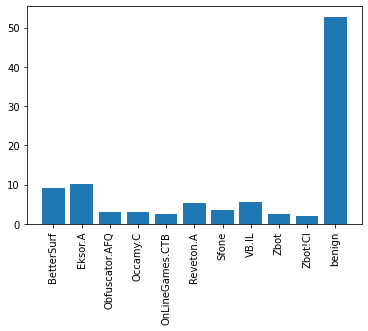

In [21]:
perc = (multi_distribution[1]/labels.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight')

In [22]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
total = trainsize + testsize

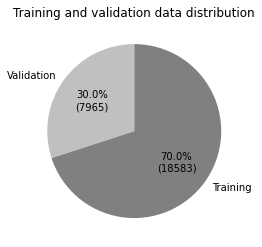

In [23]:
plt.pie(
    [trainsize, testsize], 
    labels = ["Training", "Validation"], 
    startangle=90, 
    counterclock=False, 
    autopct=my_fmt,
    colors = ['gray', 'silver']
)

plt.title("Training and validation data distribution")

if cenv == 0:
    plt.savefig("train_test_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/train_test_dist.png", bbox_inches = 'tight')

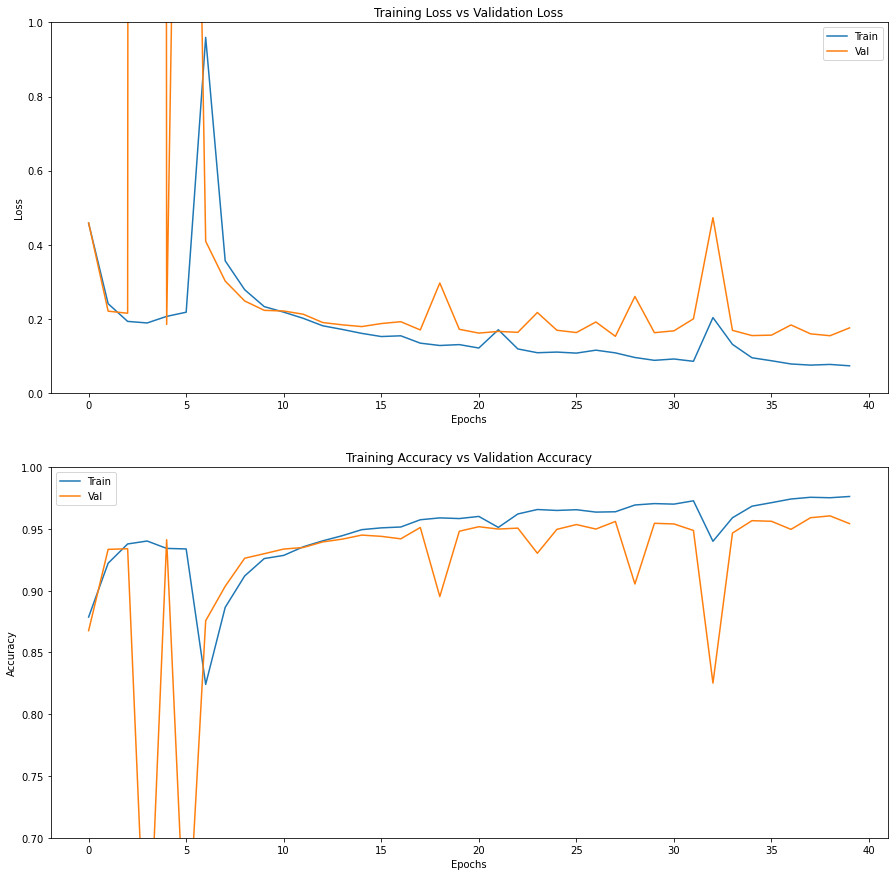

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

axs[0].set_ylim([0,1])
axs[1].set_ylim([0.7, 1])

if cenv == 0:
    plt.savefig("performance_figure.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/performance_figure.png", bbox_inches = 'tight')

# Analyse performance

**Multiclass classification**

In [25]:
from sklearn import metrics
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable, MSWORD_FRIENDLY

Multiclass performance table

In [26]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['Valididation accuracy', round(scores[1],4)])
t.add_row(['Validation loss', round(scores[0],4)])
t.header = True
t.align = "l"
t.title = "Perf. of multi-class classification - DenseNet"
print(t)

+------------------------------------------------+
| Perf. of multi-class classification - DenseNet |
+------------------------------+-----------------+
| Metric                       | Performance     |
+------------------------------+-----------------+
| Valididation accuracy        | 0.9561          |
| Validation loss              | 0.153           |
+------------------------------+-----------------+


In [27]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

In [28]:
y_pred = np.argmax(best_model.predict(X_test), axis=-1)

In [29]:
y_pred

array([10, 10, 10, ...,  7,  7,  0], dtype=int64)

In [30]:
y_test2 = y_test
y_test2

array([10., 10., 10., ...,  7.,  7.,  0.], dtype=float32)

In [31]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [32]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png")

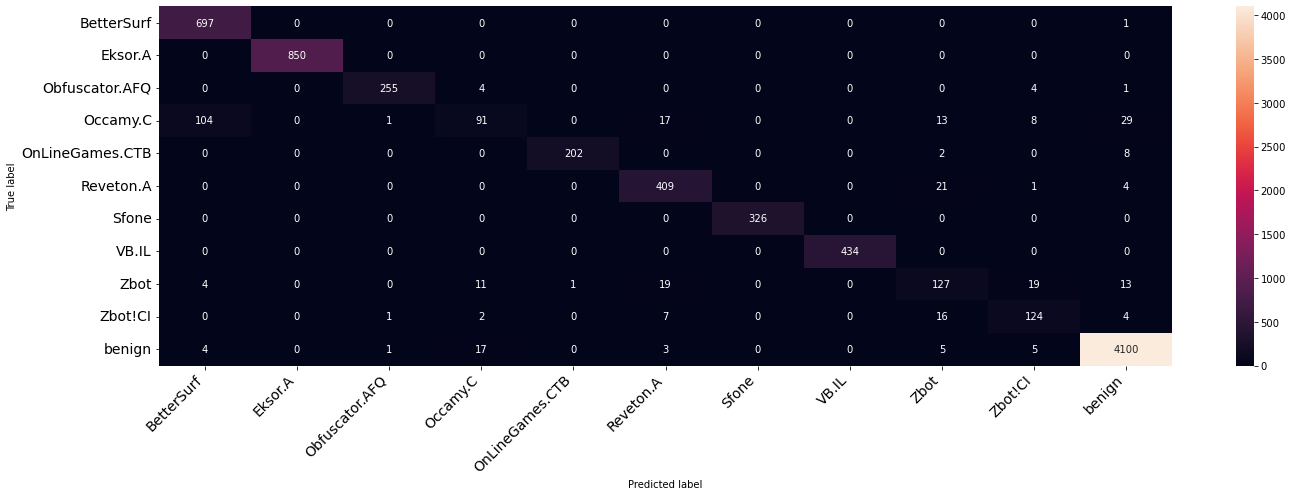

In [33]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

**Binary classification**


In [34]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [35]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
if len(y_truebin) == len(y_predbin):
    print(f"Length of the observations in test set: {len(y_truebin)}")

Length of the observations in test set: 7965


In [36]:
rw_count = 0
bn_count = 0
for count, value in enumerate(multi_distribution[1]):
    if count in range(10):
        rw_count = rw_count + multi_distribution[1][count]
    else: 
        bn_count = bn_count + multi_distribution[1][count]
print(f"Ransomware Occurences: {rw_count}, Benign Occurences: {bn_count}")

Ransomware Occurences: 12536, Benign Occurences: 14012


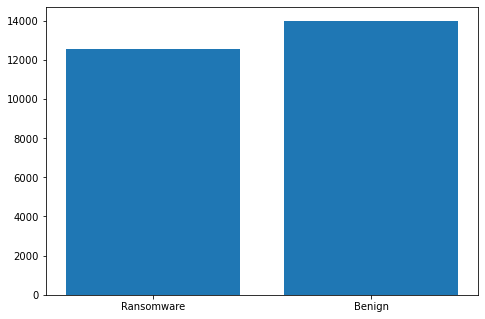

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [rw_count, bn_count]
ax.bar(x_lab, y_lab)
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight')

In [38]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)

In [39]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("DenseNet121")
    if cenv == 0:
        plt.savefig("bin_class_cmatrix.png", bbox_inches = 'tight')
    if cenv == 1:
        plt.savefig(f"{new_dir}/bin_class_cmatrix.png", bbox_inches = 'tight')

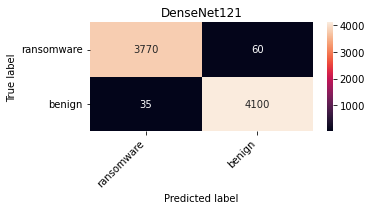

In [40]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [41]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [42]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [43]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [44]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

In [45]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of DenseNet"
print(t)

+------------------------------------------------+
|            Performance of DenseNet             |
+----------------------------------+-------------+
| Metric                           | Performance |
+----------------------------------+-------------+
| True Positive Rate               | 0.9843      |
| Accuracy                         | 0.9881      |
| F1 Score                         | 0.9885      |
| Matthews Correlation Coefficient | 0.9761      |
+----------------------------------+-------------+


In [46]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('bin_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/bin_performance_table.txt', 'w') as f:
        f.write(table)